In [1]:
import logging
import os
import sys
import math
import argparse
sys.path.append('scripts')
sys.path.append('share')
sys.path.append('python')
from collections import namedtuple
import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow
import tensorflow.keras as keras
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn

In [2]:
def doNumber(data_EC, data_Layer, data_number, data_true):

    data = {}

    outdata = np.zeros(
        (data_number.shape[0],),
        dtype=[
            ('Output_number', np.dtype(('f4', 3))),
            ('Output_number_true', 'i4'),
            ('Output_number_estimated', 'i4')
        ]
    )

    IBL = np.logical_and(data_Layer == 0, data_EC == 0)
    Barrel = np.logical_and(data_Layer > 0, data_EC == 0)
    Endcap = data_EC != 0

    outdata['Output_number'] = data_number
    outdata['Output_number_true'] = data_true

    data['IBL'] = outdata[IBL]
    data['Barrel'] = outdata[Barrel]
    data['Endcap'] = outdata[Endcap]
    return data

In [12]:
def plot_confusion_matrix(data, accuracy, labels, title, output_filename, layer):

    plt.style.use('seaborn')
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
    plt.title(f'Confusion Matrix for {title} {layer}', fontdict = {'fontsize' : 14})
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, vmin=0, vmax=1, annot=True, cmap="Greys", cbar_kws={'label': 'Cluster Density'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")

    ax.text(1, 1, f'Accuracy = {accuracy:.2f}', size='12',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.close()

In [17]:
def doMatrix(matrix):
    total = float(np.sum(matrix))
    print(total)
    correct = float(np.sum(np.diag(matrix)))
    print(correct)
    accuracy = correct / total
    matrix = matrix / np.sum(matrix, axis=1, keepdims=True)
    return accuracy, matrix

def doConfusion(data, title, outpath, thrsh):

    for layer in data:
        data[layer]['Output_number_estimated'][
            np.where(np.logical_and(data[layer]['Output_number'][:,1] < thrsh[layer][0], data[layer]['Output_number'][:,2] < thrsh[layer][1]))
        ] = 1
        data[layer]['Output_number_estimated'][
            np.where(np.logical_and(data[layer]['Output_number'][:,1] >= thrsh[layer][0], data[layer]['Output_number'][:,2] < thrsh[layer][1]))
        ] = 2
        data[layer]['Output_number_estimated'][
            np.where(data[layer]['Output_number'][:,2] >= thrsh[layer][1])
        ] = 3

        matrix = confusion_matrix(data[layer]['Output_number_true'], data[layer]['Output_number_estimated'], labels=[1,2,3])
        accuracy, matrix = doMatrix(matrix)
        plot_confusion_matrix(matrix, accuracy, ['1', '2', '3'], title, f'{outpath}{layer}_confusion.png'.replace(" ", "_"), layer)

    matrix = confusion_matrix(np.concatenate([data[x] for x in data])['Output_number_true'], \
                np.concatenate([data[x] for x in data])['Output_number_estimated'], labels=[1,2,3])
    accuracy, matrix = doMatrix(matrix)
    plot_confusion_matrix(matrix, accuracy, ['1', '2', '3'], title, f'{outpath}total_confusion.png'.replace(" ", "_"), 'All Layers')
        

In [36]:
print(np.count_nonzero(data['Endcap']['Output_number_true'] == 1))

16763


In [21]:
with h5.File(f'data/dijet7w.h5', 'r') as data:
    data_x = data['input'][()]
    data_Layer = data_x[:,0]
    data_EC = data_x[:,1]
    data_true = data_x[:,2]
    data_true[np.where(data_true==0)] = 3 #All truth values of >3 particles are set to 3 particles
    data_2pr = data_x[:,3]
    data_3pr = data_x[:,4]
    data_1pr = 1-data_2pr-data_3pr
    data_number = np.ndarray((data_1pr.shape[0],3))
    data_number[:,0] = data_1pr
    data_number[:,1] = data_2pr
    data_number[:,2] = data_3pr

data = doNumber(data_EC, data_Layer, data_number, data_true)


bestThresh = {'IBL' : [0.83,0.52], 'Barrel' : [0.82,0.81], 'Endcap' : [0.99,0.91]}
outpath = "output/final/"
doConfusion(data, 'Best Incremented Threshold', outpath, bestThresh)

145067.0
130766.0
466523.0
401538.0
19008.0
16763.0
630598.0
549067.0


In [4]:
print(data_number.shape)

(362711, 3)


In [10]:
def doAccuracy(matrix):
    total = float(np.sum(matrix))
    correct = float(np.sum(np.diag(matrix)))
    accuracy = correct / total
    return accuracy

bestThresh = {'IBL' : [0,0], 'Barrel' : [0,0], 'Endcap' : [0,0]}
for k, layer in enumerate(data):
    accuracy = 0
    for thrs1 in np.linspace(0.1, 1, 10):
        for thrs2 in np.linspace(0.1, 1, 10):
            thrs = [thrs1, thrs2]
                
            data[layer]['Output_number_estimated'][
                np.where(np.logical_and(data[layer]['Output_number'][:,1] < thrs[0], data[layer]['Output_number'][:,2] < thrs[1]))
            ] = 1
            data[layer]['Output_number_estimated'][
                np.where(np.logical_and(data[layer]['Output_number'][:,1] >= thrs[0], data[layer]['Output_number'][:,2] < thrs[1]))
            ] = 2
            data[layer]['Output_number_estimated'][
                np.where(data[layer]['Output_number'][:,2] >= thrs[1])
            ] = 3

            matrix = confusion_matrix(data[layer]['Output_number_true'], data[layer]['Output_number_estimated'], labels=[1,2,3])

            tempAccuracy = doAccuracy(matrix)
            
            if accuracy > tempAccuracy:
                pass
                # print('worse')
                # print(f'{tempAccuracy:4f} < {accuracy:4f}')
            else:
                # print('better')
                # print(f'{tempAccuracy:4f} >= {accuracy:4f}')
                bestThresh[layer] = thrs
                accuracy = tempAccuracy

    print(f"Best Threshold for {layer}: {bestThresh[layer]}, with accuracy: {accuracy}")
print(f"Best Threshold: {bestThresh}")

Best Threshold for IBL: [0.8, 0.6], with accuracy: 0.9217755846506235
Best Threshold for Barrel: [0.8, 0.9], with accuracy: 0.9388433585897634
Best Threshold for Endcap: [1.0, 1.0], with accuracy: 0.999582587954681
Best Threshold: {'IBL': [0.8, 0.6], 'Barrel': [0.8, 0.9], 'Endcap': [1.0, 1.0]}


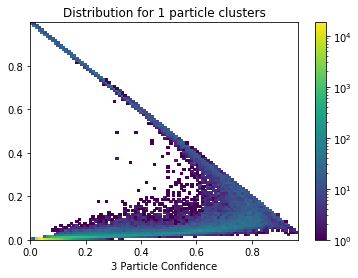

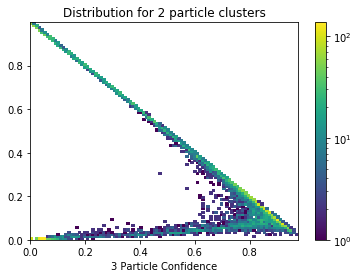

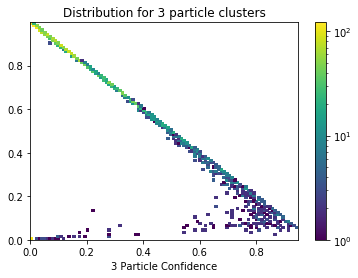

In [23]:
for i in range(1, 4):
    isel = np.where(data['IBL']['Output_number_true'] == i)
    x = data['IBL']['Output_number'][isel][:,1]
    y = data['IBL']['Output_number'][isel][:,2]

    plt.hist2d(x, y, bins=(100,100), norm=mcolors.LogNorm())
    plt.title(f'Distribution for {i} particle clusters')
    plt.xlabel('2 Particle Confidence')
    plt.xlabel('3 Particle Confidence')
    cbar = plt.colorbar()
    cbar.set_label('')
    plt.show()
    plt.close()